<a href="https://colab.research.google.com/github/nina-adhikari/enjoyment-maximizing-maps/blob/main/mvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# packages that need to be installed
!pip install mapclassify # Choropleth map classification; basically for Geopandas

In [2]:
# packages that need to be loaded
import matplotlib.pyplot as plt #for the pandas profiling
import geopandas as gpd #extends the datatypes used by pandas to allow spatial operations on geometric types
import pandas as pd
import numpy as np
import pickle

# 1. Importing and cleaning data

In [3]:
# global variables to be defined
DIR = 'drive/MyDrive/walkability/'   # directory where all files are stored
HEALTH_OUTCOME = 'LPA'

# datasets stored in drive/MyDrive/walkability/
health = DIR + 'health.csv'      # 500 Cities: Local Data for Better Health https://data.cdc.gov/500-Cities-Places/500-Cities-Local-Data-for-Better-Health-2019-relea/6vp6-wxuq/about_data
epacsv = DIR + 'epdownload.csv'  # Smart Location Database https://edg.epa.gov/EPADataCommons/public/OA/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv
income = DIR + 'income.csv'      # Median household income https://data.census.gov/table/ACSDT5Y2017.B19013?q=b19013&g=040XX00US11$1400000&moe=false&tp=true
walk_gdb = DIR + 'walk_index.gdb'

# allow colab to access your Google Drive, an authentication window will pop-up
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Import the Income dataset:

In [4]:
inc = gpd.read_file(income).drop('geometry', axis=1)                            # converts GeoDataFrame to a normal DataFrame by dropping the geometry column?
inc['Income'] = inc['Income'].str.replace(',','')                               # replace comma format for numbers
inc = inc.apply(pd.to_numeric, errors='coerce')                                 # convert to numeric, coerce makes invalid parsing be set as NaN
inc['Tract'] = round(inc['Tract'].astype(float)*100).astype(int)                # format census tract id as integer
inc.set_index('Tract', inplace=True)                                            # tract id is the index of this dataframe

Import the SLD dataset:

In [5]:
columns_to_drop = ['GEOID20', 'CSA', 'CSA_Name', 'CBSA', 'CBSA_Name', 'CBSA_POP', 'CBSA_EMP', 'CBSA_WRK']
epa_init = gpd.read_file(epacsv, where="STATEFP='11'").drop(columns=columns_to_drop)   # only interested in DC

# GEO ID data is corrupted in csv because it was stored as a float, so we generate it using other data and padding
epa_init['GEOID10'] = epa_init['STATEFP'].str.zfill(2) + epa_init['COUNTYFP'].str.zfill(3) + epa_init['TRACTCE'].str.zfill(6) + epa_init['BLKGRPCE']

epa_init['TRACTCE'] = epa_init['TRACTCE'].astype(int)                           # format as integer to use for merging later
epa_init.set_index('OBJECTID', inplace=True)

Since the CSV doesn't have geometry data for plotting, we import it from another file (which comes from the same EPA dataset):

In [ ]:
gdb = gpd.read_file(walk_gdb, where="STATEFP='11'")[['GEOID10', 'geometry']]
gdb['GEOID10'] = gdb['GEOID10'].astype(int)
gdb.set_index('GEOID10', inplace=True)
epa_init['GEOID10'] = epa_init['GEOID10'].astype(int)
epa = epa_init.join(other=gdb, on='GEOID10', how='left', validate='1:1', lsuffix='epa')
epa.drop(columns=['geometryepa'], inplace=True)
epa

Import the health dataset:

In [7]:
hl = gpd.read_file(health, where="StateAbbr='DC' AND GeographicLevel='Census Tract'", include_fields=['StateAbbr', 'GeographicLevel', 'UniqueID', 'MeasureId', 'CityFIPS', 'TractFIPS', 'Data_Value'])
hl['TractCE'] = hl['TractFIPS'].str.removeprefix('110010').astype(int)          # format index column
hlp = hl.pivot(index='TractCE', columns='MeasureId', values='Data_Value')       # pivot table to have the columns be the MeasureId

Merge all datasets:

In [ ]:
firstjoin = epa.join(other=inc, on='TRACTCE', how='left', validate='m:1')                   # merge EPA and income data
secondjoin = firstjoin.join(other=hlp[HEALTH_OUTCOME], on='TRACTCE', how='left', validate='m:1')     # merge above with CDC data
secondjoin = secondjoin.apply(pd.to_numeric, errors='ignore')
secondjoin

Further cleaning:

In [9]:
# Some of the entries are set to -99999 (see the PDF, page 23 footnote 65), so we will replace them (and in fact all negative entries) with NaN:
secondjoin[secondjoin.drop(columns=['geometry']) < 0] = np.nan

# Drop the rows that have NaNs
df_full = secondjoin.dropna()

# Columns we ignore when doing numerical operations
non_numeric_columns = ['GEOID10', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'Shape_Length', 'Shape_Area', 'geometry']

df_geo = df_full['geometry']                                                    # The GeoDataFrame that has mapping info
df = df_full.drop(columns=non_numeric_columns)                                  # The purely numeric dataframe that we will use for regressions

In [10]:
# open dictionary that contains the explanation of each column name
picklefile = DIR + 'cols_dict.pickle'
with open(picklefile, 'rb') as handle:
    cols_dict = pickle.load(handle)

# 2. Feature selection

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import PredictionErrorDisplay


## a. Lasso

Set up some basic settings:

In [12]:
features = list(df.drop(columns=[HEALTH_OUTCOME]).columns)

## These are the features that need to be scaled
scale_columns = range(len(features))

ITERS = 5

#lasso hyperparameter
ALPHAS = [.0001,.001,.01,.1,.25,.5,.75,1,5,10,25,50,100,1000,10000] #15

SEED = 47
rng = np.random.default_rng(SEED)

In [13]:
MAX_ITERATIONS = 1000000
TOLERANCE = 0.001

def lasso_for_one_dataset(dataset, outcomes):
  #initialize min_idx array
  min_idx = np.zeros(len(features))

  ## make coefficient holder
  coefs = np.zeros((len(ALPHAS), len(features)))

  ## Loop through alphas
  for i in range(len(ALPHAS)):
    ## make lasso model
    lasso = Lasso(alpha=ALPHAS[i], max_iter=MAX_ITERATIONS, tol=TOLERANCE, fit_intercept=False)

    ## fit model
    lasso.fit(dataset, outcomes)

    ## record coefs
    coefs[i,:] = lasso.coef_
    coef_df = pd.DataFrame(data=coefs, index=ALPHAS, columns=features)
    prev_min_idx = min_idx
    min_idx = coef_df.ne(0).idxmin().values

    if (min_idx == prev_min_idx).all():
      break
  return min_idx

In [14]:
# We want to do the randomization multiple times
min_idx = np.zeros((len(features), ITERS))

# Get some random states
states = rng.integers(low=10, high=70, size=5)

for i in range(ITERS):
  ## make a train test split here
  df_copy = df.copy()
  urban_train, urban_test = train_test_split(
    df_copy,
    shuffle = True,
    random_state = states[i],
    test_size = .8
    )
  ## scale quantitative variables
  urban_train_array = urban_train[features].to_numpy()
  scaler = StandardScaler()

  urban_train_array_scaled = urban_train_array.copy()
  urban_train_array_scaled[:,scale_columns] = scaler.fit_transform(urban_train_array_scaled[:,scale_columns])

  min_idx[:,i] = lasso_for_one_dataset(urban_train_array_scaled, urban_train[HEALTH_OUTCOME].values)

min_idx_df = pd.DataFrame(data=min_idx, index=features, columns=range(ITERS))

In [ ]:
#add a score col and sort
min_idx_df['score'] = np.round(min_idx_df.sum(axis=1, numeric_only=True), 1)
misorted = min_idx_df.sort_values(by=['score'], ascending=False)
misorted

Only keep features above a certain threshold:

In [96]:
THRESHOLD = 0.0

features_of_interest = list(misorted.loc[misorted['score'] > THRESHOLD].index)
#df_reg = df.copy()[features_of_interest]

#scaler = StandardScaler().set_output(transform="pandas")
#df_reg = scaler.fit_transform(df_reg)
#df_reg[HEALTH_OUTCOME] = df[HEALTH_OUTCOME]
#df_reg

## b. Profiling

In [ ]:
!pip install ydata-profiling # Data profiling and exploratory data analysis
from ydata_profiling import ProfileReport #automatic profiling of datasets


In [ ]:
report = ProfileReport(df, minimal=True)
report

## c. Checking correlations

In [239]:
cols_dict

{'GEOID10': 'Census block group 12-digit FIPS code (2010)',
 'GEOID20': 'Census block group 12-digit FIPS code (2018)',
 'STATEFP': 'State FIPS code',
 'COUNTYFP': 'County FIPS cod',
 'TRACTCE': 'Census tract FIPS code in which CBG resides',
 'BLKGRPCE': 'Census block group FIPS code in which CBG resides',
 'CSA': 'Combined Statistical Area (CSA) Code',
 'CSA_Name': 'Name of CSA in which CBG resides',
 'CBSA': 'FIPS for Core-Based Statistical Area (CBSA) in which\nCBG resides',
 'CBSA_Name': 'Name of CBSA in which CBG resides',
 'CBSA_POP': 'Total population in CBSA',
 'CBSA_EMP': 'Total employment in CBSA',
 'CBSA_WRK': 'Total number of workers that live in CBSA',
 'Ac_Total': 'Total geometric area (acres) of the CBG',
 'Ac_Water': 'Total water area (acres)',
 'Ac_Land': 'Total land area (acres)',
 'Ac_Unpr': 'Total land area (acres) that is not protected from\ndevelopment (i.e., not a park, natural area or conservation\narea)',
 'TotPop': 'Population, 2018',
 'CountHU': 'Housing unit

In [238]:
pd.DataFrame(data=df.corr().abs().loc[HEALTH_OUTCOME])

,LPA
Ac_Total,0.074302
Ac_Water,0.061274
Ac_Land,0.065328
Ac_Unpr,0.058083
TotPop,0.038739
...,...
D3B_Ranked,0.202410
D4A_Ranked,0.008049
NatWalkInd,0.395811
Income,0.810306


## d. Conclusion

Based on the above data analysis and our study of the source data, we choose to keep the following features:

In [39]:
final_features = ['D1A',
                  'D1B',
                  'D1C',
                  'D2A_JPHH',
                  'D2A_EPHHM',
                  'D3APO',
                  'D3B',
                  'D4A',
                  'D4E',
                  'D5CR',
                  'D5DR',
                  'Income'
                  ]

In [40]:
df_reg = df.copy()[final_features]

scaler = StandardScaler().set_output(transform="pandas")
df_reg = scaler.fit_transform(df_reg)
df_reg[HEALTH_OUTCOME] = df[HEALTH_OUTCOME]
df_reg

,D1A,D1B,D1C,D2A_JPHH,D2A_EPHHM,D3APO,D3B,D4A,D4E,D5CR,D5DR,Income,LPA
OBJECTID,,,,,,,,,,,,,
61344,0.723778,-0.103284,2.969873,0.512435,1.386538,-0.617272,0.167699,-0.204992,1.310083,0.895402,0.807348,0.345804,12.6
61345,1.127510,0.507901,-0.024932,-0.143180,0.663575,0.421914,2.314366,-0.152555,0.533443,1.284138,0.840876,1.234438,14.3
61346,1.481985,0.528836,0.758970,-0.043362,1.409017,-0.093644,0.642594,0.092410,0.830787,1.993524,1.185685,0.421918,12.7
61347,2.243874,1.199277,0.345384,-0.132422,1.124684,-1.953695,-0.835595,-0.327475,1.214884,1.889559,1.385994,0.085399,13.6
61348,5.642516,5.206004,-0.164986,-0.192372,-0.732975,1.776892,-0.289754,-0.546156,0.087325,1.821020,2.722570,0.032834,19.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61789,2.030780,0.820511,-0.306541,-0.196921,-1.405891,-1.521099,-0.767672,-0.397455,-0.421280,0.232964,0.117346,-0.319284,16.4
61790,1.279727,0.787995,-0.287871,-0.193319,-1.175564,-1.791513,-0.839476,-0.589854,-0.597788,0.112260,-0.277734,0.074315,17.1
61791,-0.840302,-1.107341,-0.304583,-0.134918,1.109326,-1.134290,-1.027548,0.704627,1.103645,-0.784100,1.115862,0.580110,14.6


# 3. Learning

## a. Linear Regression

We start off with a simple linear regression to see what the residuals look like:

In [106]:
X = df_reg.drop(columns=[HEALTH_OUTCOME])
y = df_reg[HEALTH_OUTCOME]

lr = LinearRegression(copy_X=True)

lr.fit(X, y)

LinearRegression()

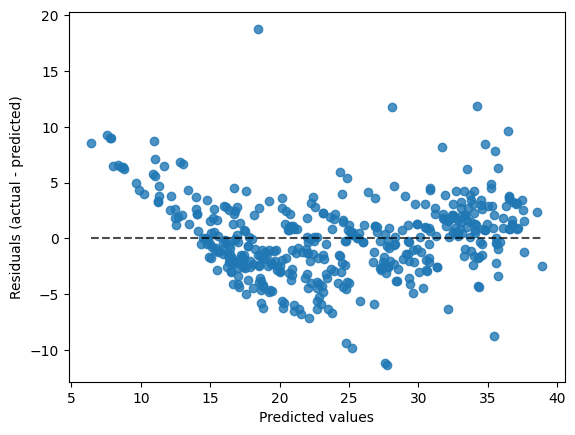

In [107]:
y_pred = lr.predict(X)
display = PredictionErrorDisplay(y_true=y, y_pred=y_pred)
display.plot()

These do not look randomly distributed.

In [108]:
coeffs = pd.DataFrame(data=lr.coef_.round(2), index=X.columns)
coeffs

,0
D1A,-1.77
D1B,1.15
D1C,-0.27
D2A_JPHH,-0.19
D2A_EPHHM,-0.16
D3APO,0.46
D3B,-0.40
D4A,-0.01
D4E,0.61
D5CR,-0.38


In [109]:
lr.intercept_

24.290604026845642

In [110]:
lr.score(X, y)

0.8290558831457748

Checking dependence of dependent variable on each feature separately:

<Figure size 640x480 with 0 Axes>

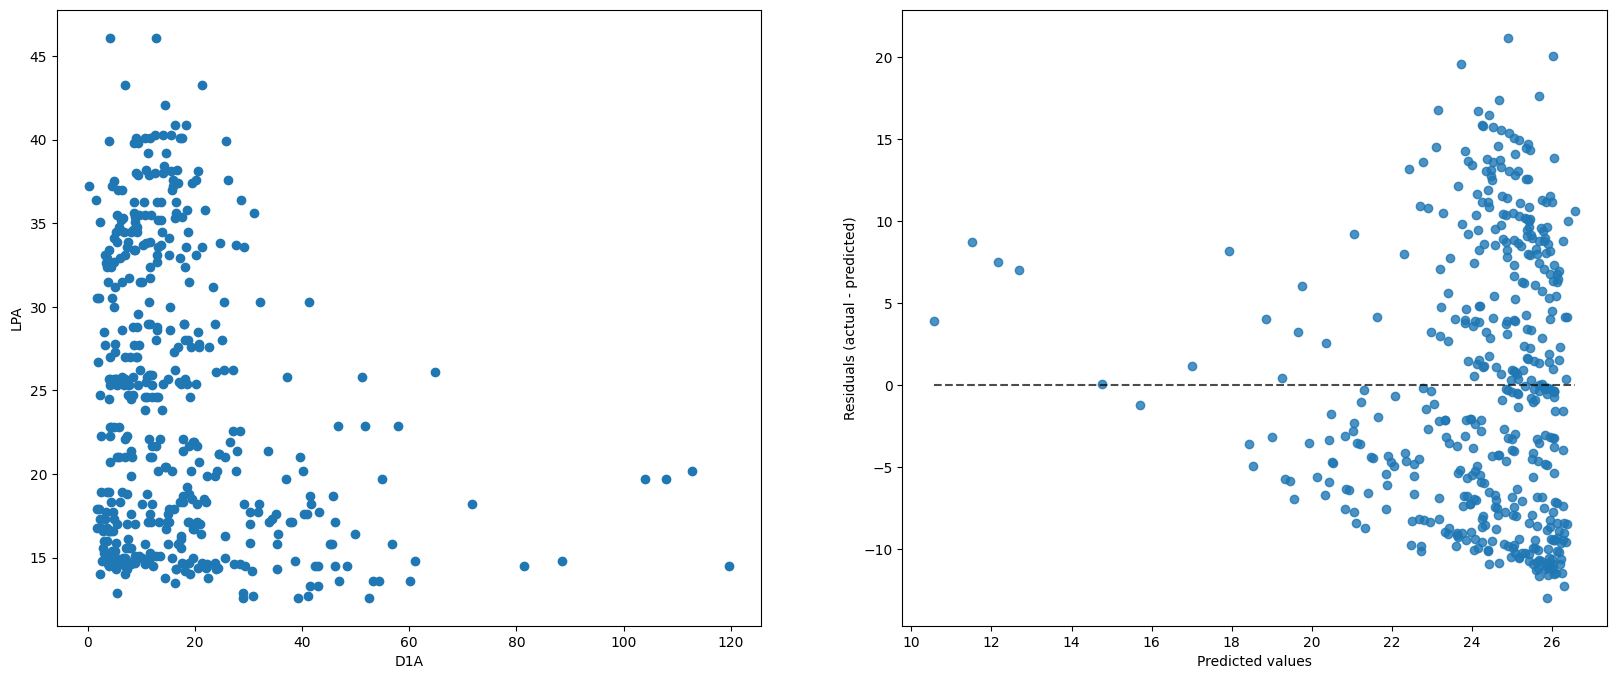

<Figure size 640x480 with 0 Axes>

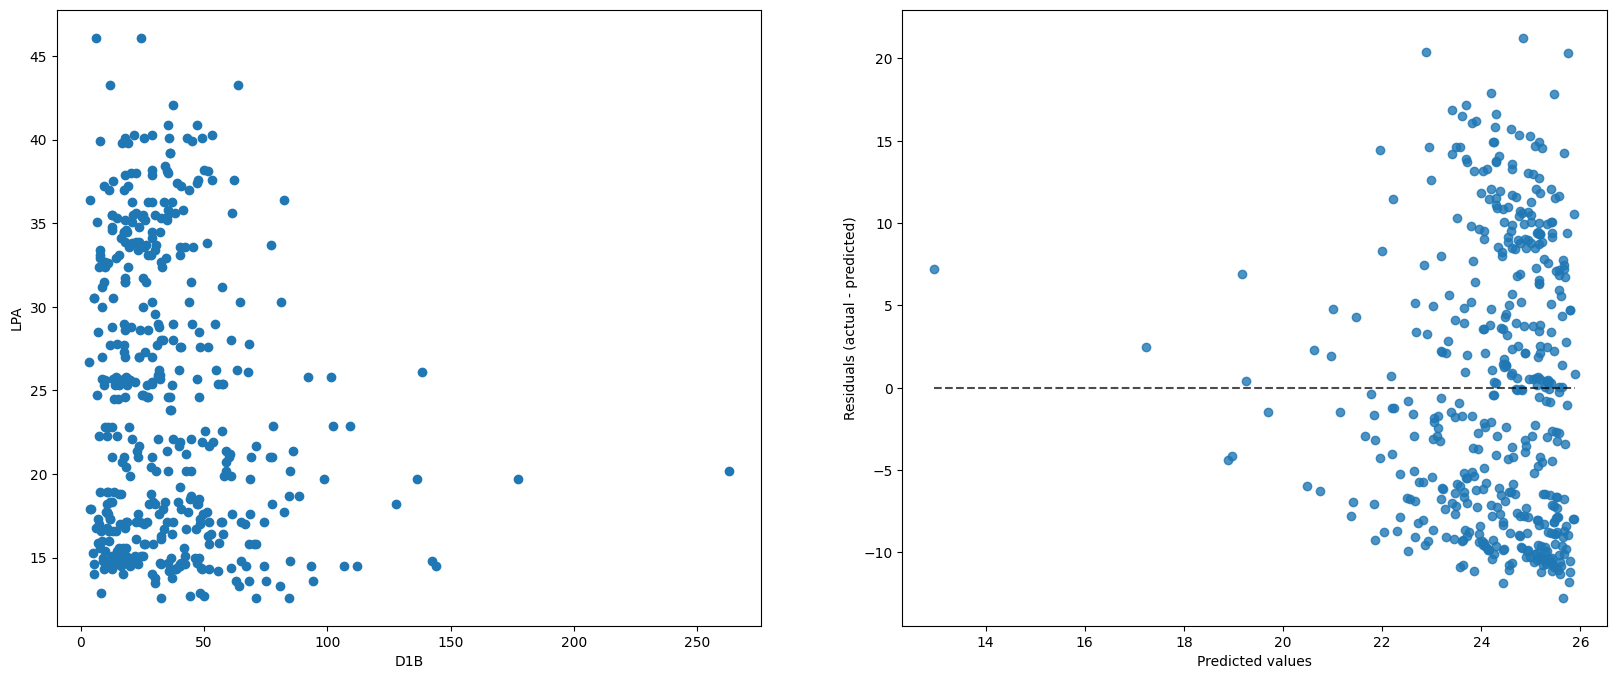

<Figure size 640x480 with 0 Axes>

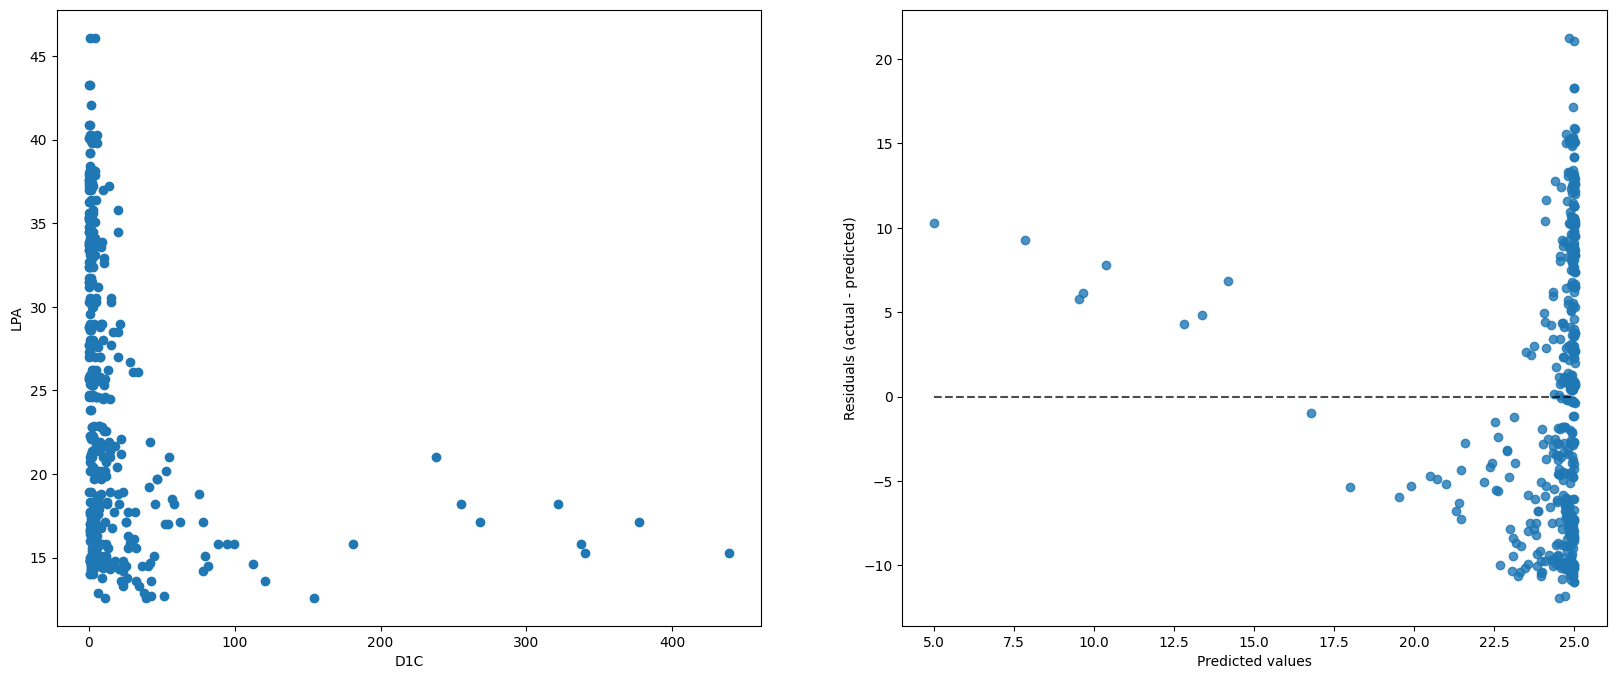

<Figure size 640x480 with 0 Axes>

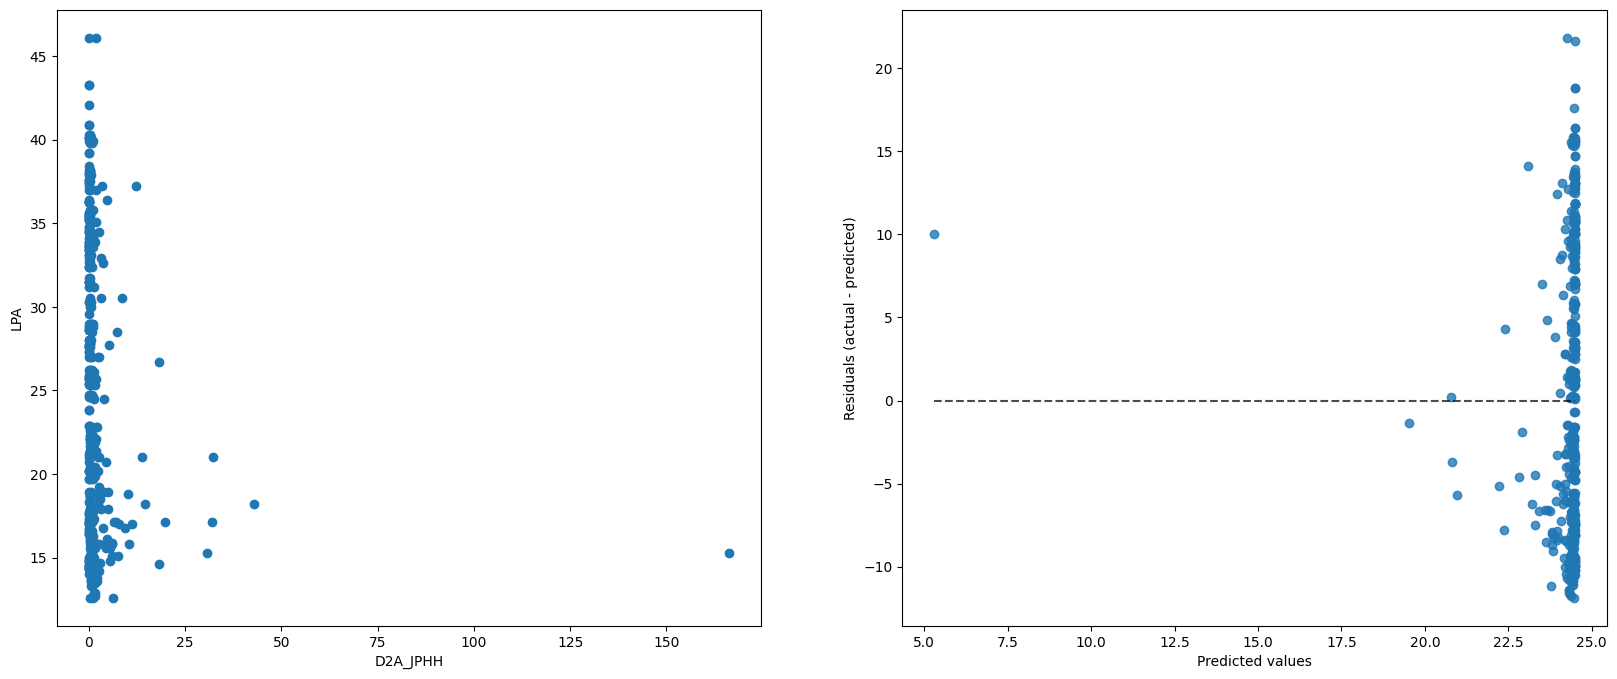

<Figure size 640x480 with 0 Axes>

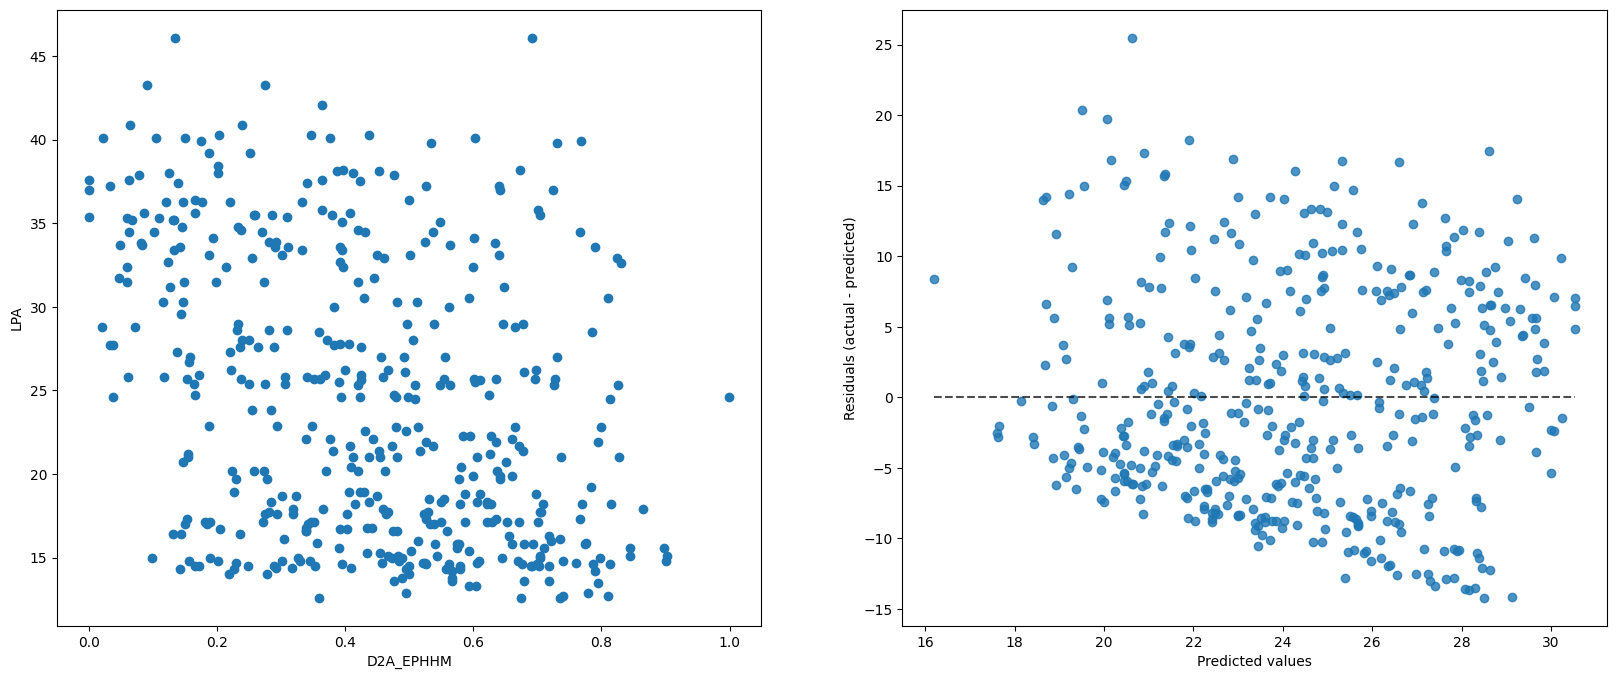

<Figure size 640x480 with 0 Axes>

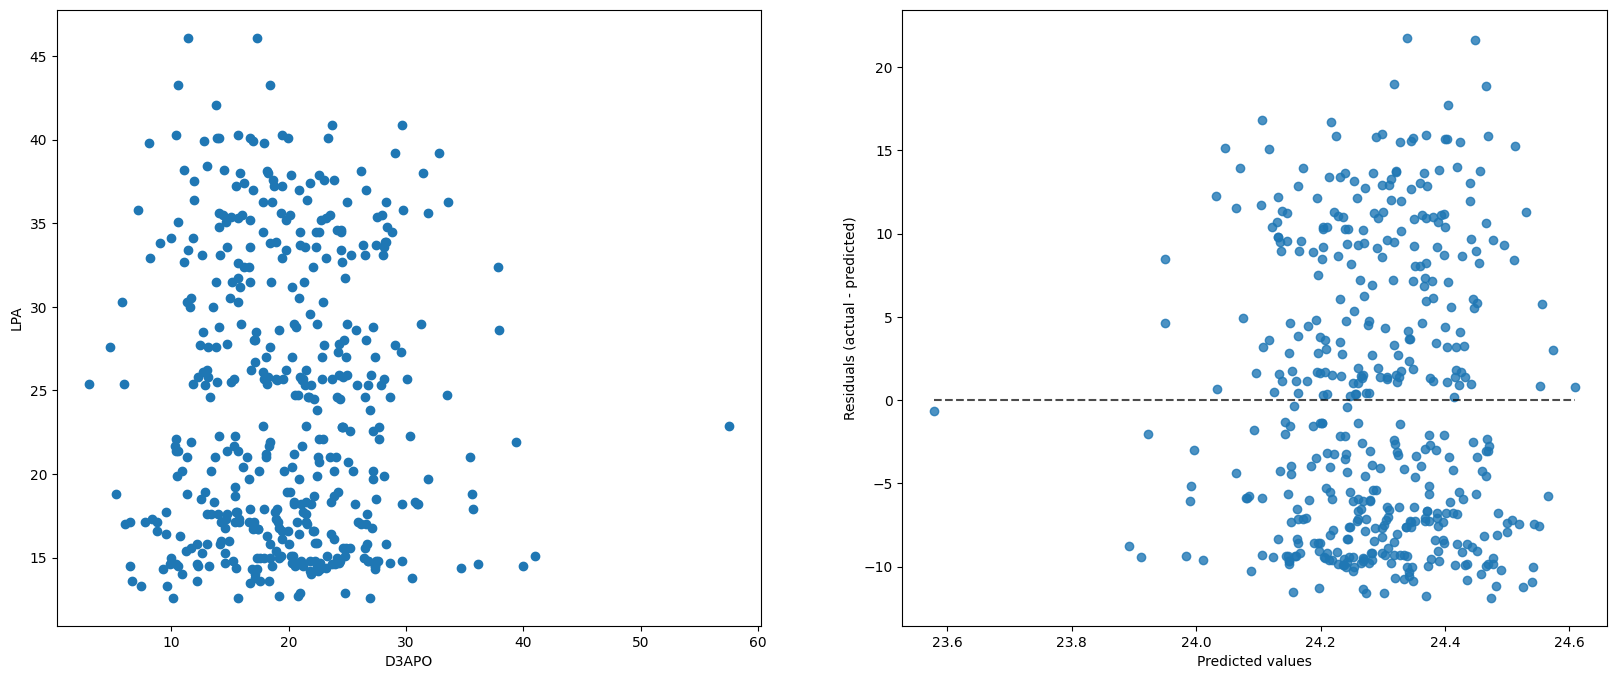

<Figure size 640x480 with 0 Axes>

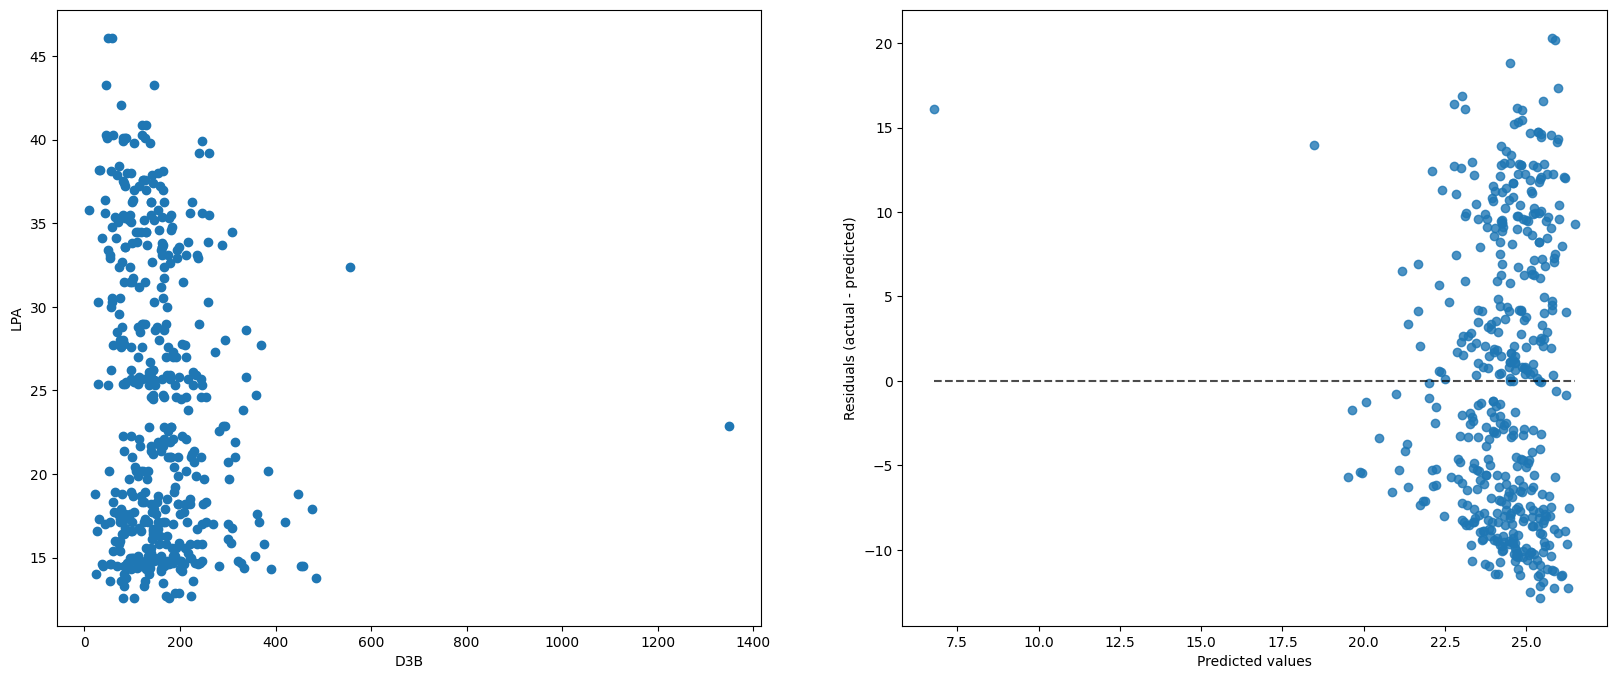

<Figure size 640x480 with 0 Axes>

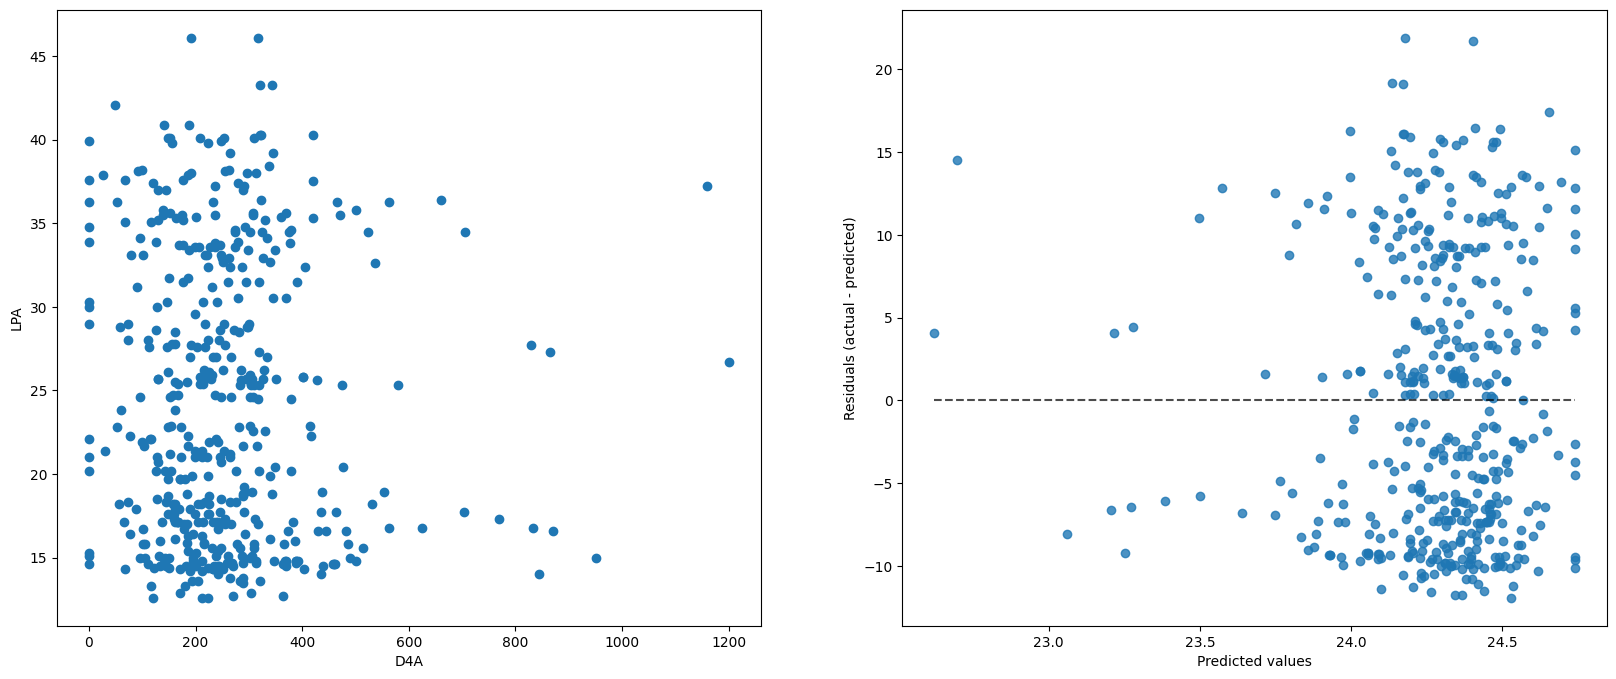

<Figure size 640x480 with 0 Axes>

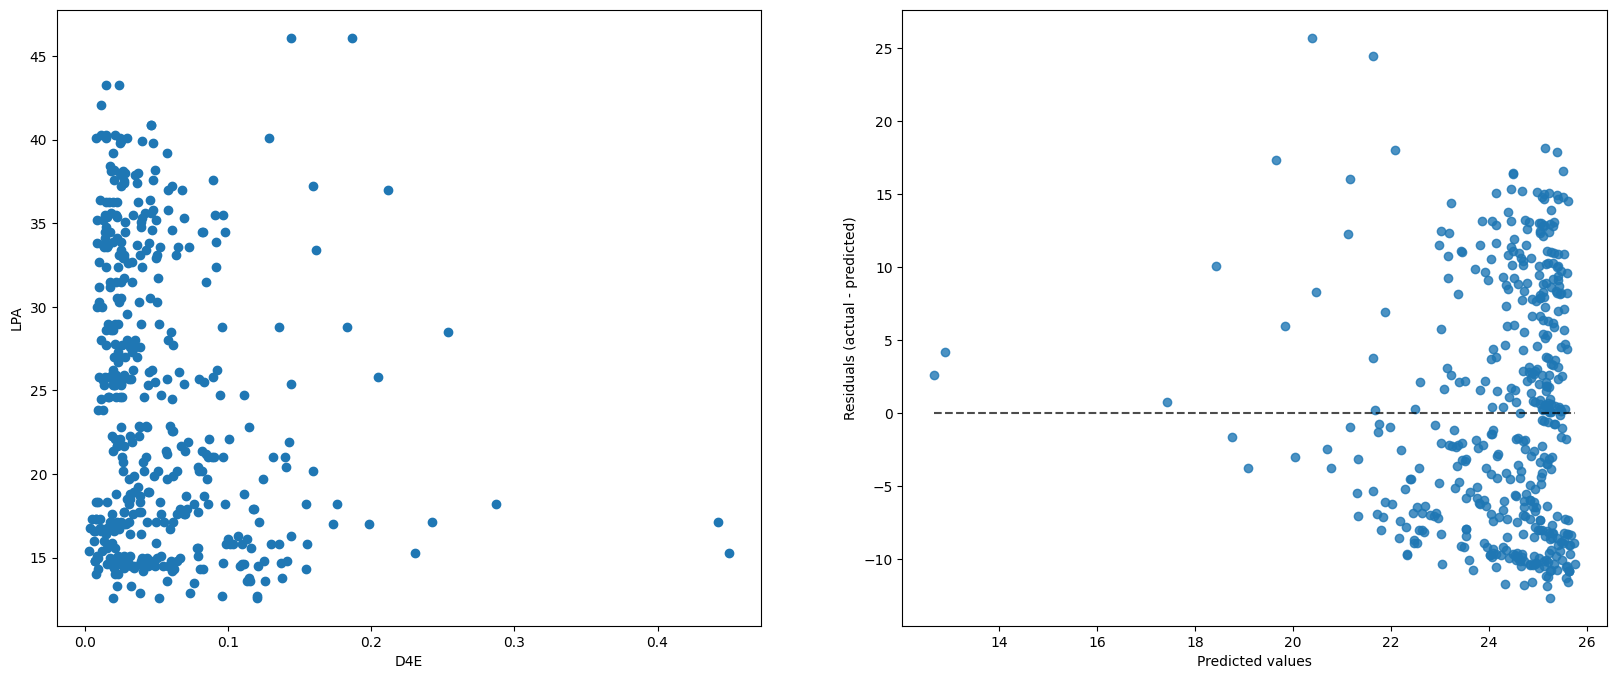

<Figure size 640x480 with 0 Axes>

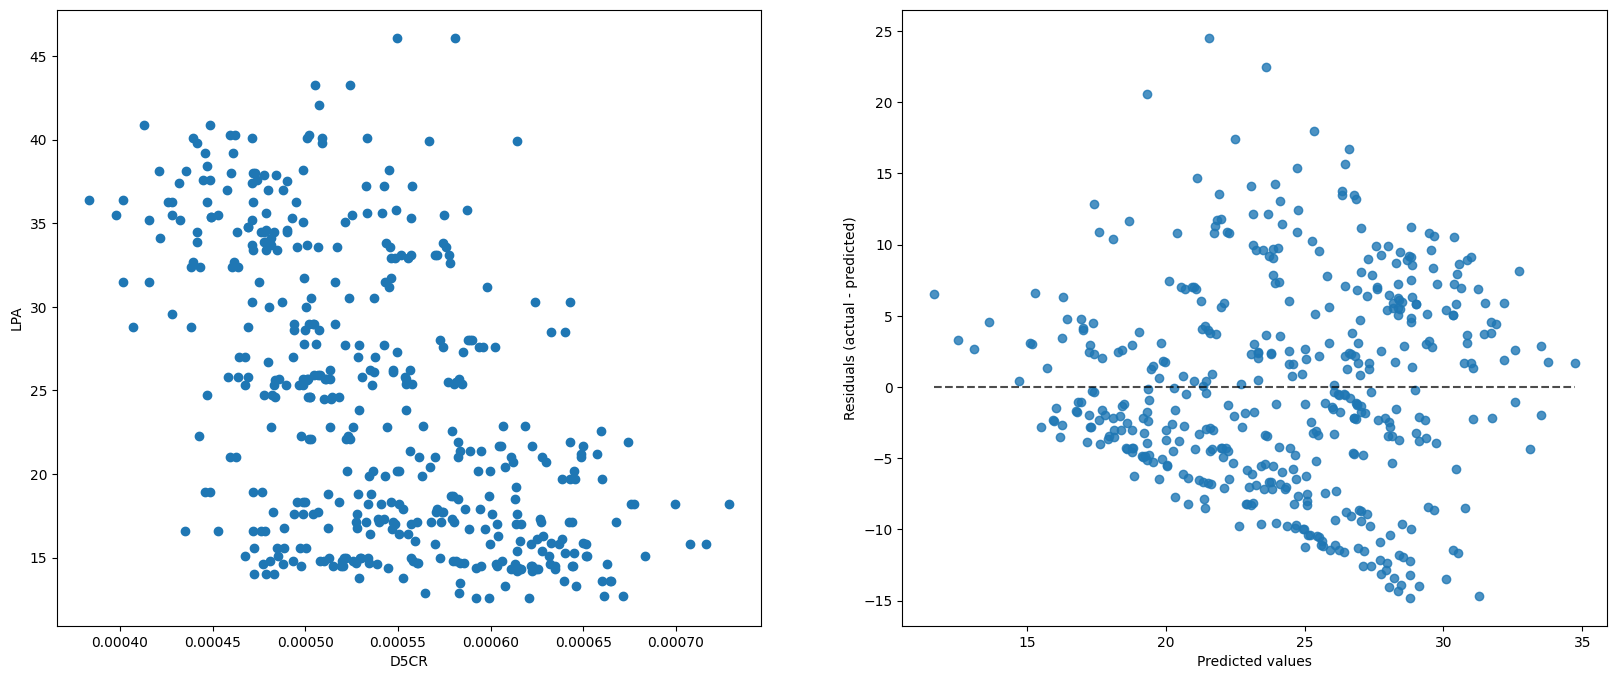

<Figure size 640x480 with 0 Axes>

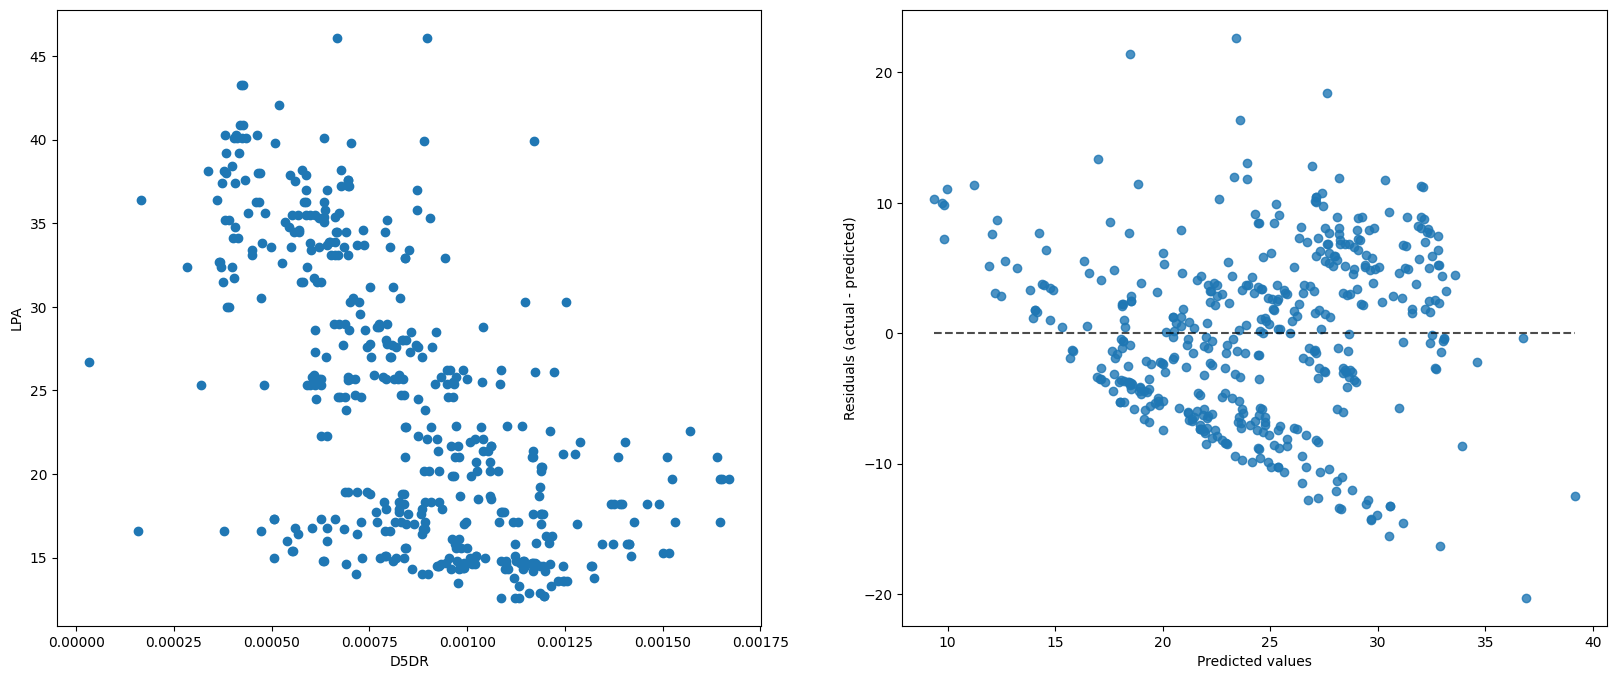

<Figure size 640x480 with 0 Axes>

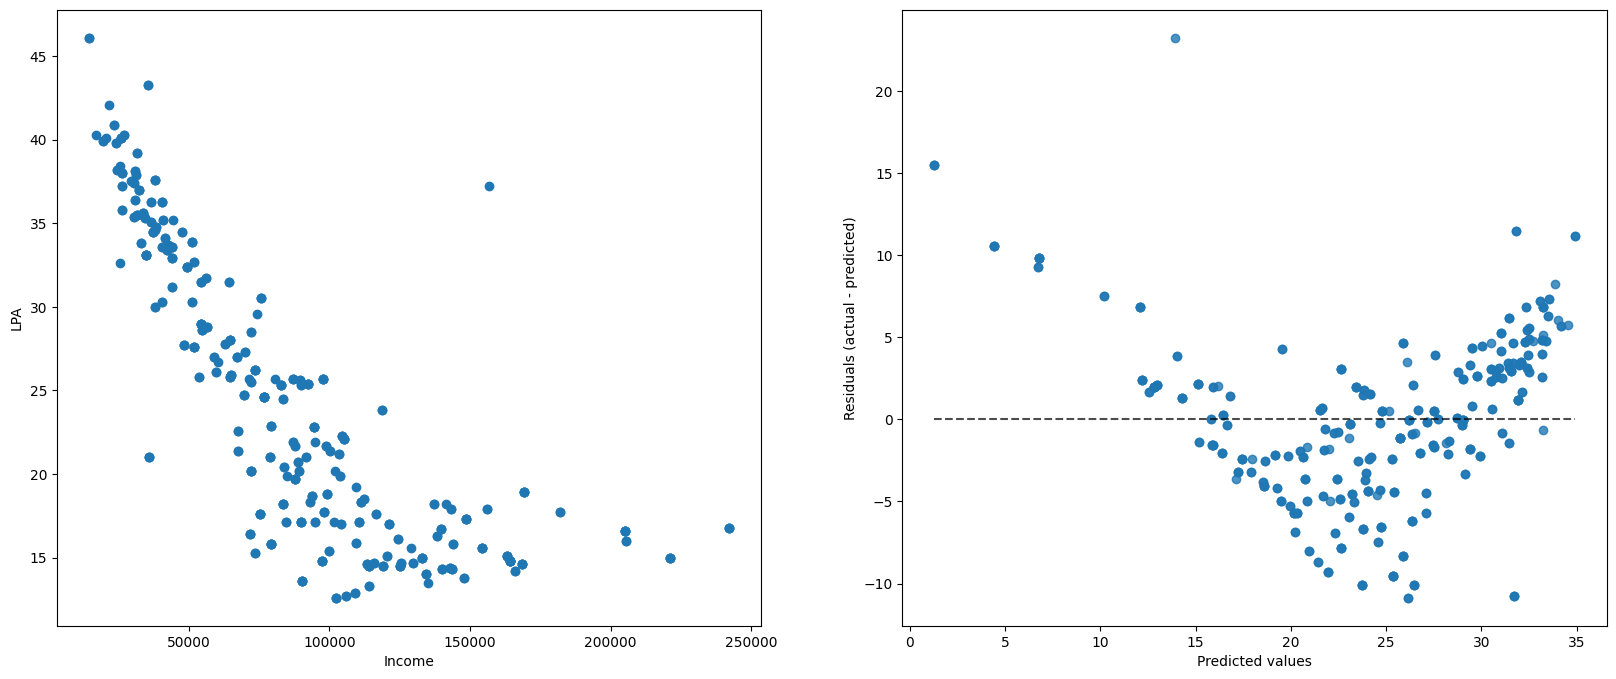

In [143]:
scores = pd.DataFrame(data=0.0, index=final_features, columns=["score"])

for feature in final_features:
  lr = LinearRegression()
  X_single = pd.DataFrame(data=df.copy()[feature])
  lr.fit(X=X_single, y=y)
  scores.loc[feature].score = lr.score(X_single, y)
  y_pred_sing = lr.predict(X_single)

  plt.clf()
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
  #plt.figure()
  plt.subplot(121)
  plt.scatter(x=X_single, y=y)
  plt.xlabel(feature)
  plt.ylabel(HEALTH_OUTCOME)

  plt.subplot(122)
  display = PredictionErrorDisplay(y_true=y, y_pred=y_pred_sing)
  display.plot(ax=ax2)
  plt.show()

In [144]:
scores

,score
D1A,0.064810
D1B,0.025800
D1C,0.063225
D2A_JPHH,0.014306
D2A_EPHHM,0.134705
D3APO,0.000227
D3B,0.030400
D4A,0.001027
D4E,0.031446
D5CR,0.273518


## b. Studying dependence of $R^2$ on features

In [154]:
import statsmodels.api as sm

def ols(X_df, y_df):
  X_wc = X_df.copy()
  X_wc = sm.add_constant(X_wc)
  reg_model=sm.OLS(y_df, X_wc)
  return reg_model.fit()

print(ols(X, y).summary())

                            OLS Regression Results                            
Dep. Variable:                    LPA   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     175.4
Date:                Wed, 17 Apr 2024   Prob (F-statistic):          5.72e-158
Time:                        01:03:23   Log-Likelihood:                -1192.8
No. Observations:                 447   AIC:                             2412.
Df Residuals:                     434   BIC:                             2465.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.2906      0.167    145.045      0.0

In [153]:
X_everything = df.copy()[features_of_interest]
print(ols(X_everything, y).summary())

                            OLS Regression Results                            
Dep. Variable:                    LPA   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     77.52
Date:                Wed, 17 Apr 2024   Prob (F-statistic):          1.31e-185
Time:                        01:03:12   Log-Likelihood:                -969.01
No. Observations:                 447   AIC:                             2084.
Df Residuals:                     374   BIC:                             2384.
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.054e+06   4.02e+05      2.621   

In [155]:
big_results = pd.DataFrame(data=0.0, index=features_of_interest, columns=["rsquared", "rsquared_adj"])
for feature in features_of_interest:
  X_big = df.copy()[features_of_interest].drop(columns=[feature])
  result = ols(X_big, y)
  #print(result.summary())
  big_results.loc[feature].rsquared = result.rsquared
  big_results.loc[feature].rsquared_adj = result.rsquared_adj

big_results

,rsquared,rsquared_adj
R_PCTLOWWAGE,0.918564,0.903145
Income,0.920122,0.904998
R_MedWageWk,0.924660,0.910396
D5BR,0.937200,0.925110
D5DR,0.937201,0.925111
...,...,...
E5_Off,0.937201,0.925111
E_LowWageWk,0.937201,0.925111
E8_off,0.937201,0.925311
E8_Ind,0.937201,0.925111


For each feature we haven't included, explore how its inclusion would change the score:

In [157]:
results = pd.DataFrame(data=0.0, index=features_of_interest, columns=["rsquared", "rsquared_adj"])
for feature in list(results.index):
  if feature in final_features:
    continue
  X_big = df.copy()[final_features + [feature]]
  result = ols(X_big, y)
  results.loc[feature].rsquared = result.rsquared
  results.loc[feature].rsquared_adj = result.rsquared_adj

results

,rsquared,rsquared_adj
R_PCTLOWWAGE,0.881073,0.877503
Income,0.000000,0.000000
R_MedWageWk,0.844458,0.839788
D5BR,0.829056,0.824329
D5DR,0.000000,0.000000
...,...,...
E5_Off,0.829701,0.824588
E_LowWageWk,0.831552,0.826494
E8_off,0.829065,0.823933
E8_Ind,0.831238,0.826171


For each feature we have included, explore how its exclusion would change the score:

In [160]:
results2 = pd.DataFrame(data=0.0, index=final_features, columns=["rsquared", "rsquared_adj"])
for feature in final_features:
  X_big = df.copy()[final_features].drop(columns=[feature])
  result = ols(X_big, y)
  results2.loc[feature].rsquared = result.rsquared
  results2.loc[feature].rsquared_adj = result.rsquared_adj

results2

,rsquared,rsquared_adj
D1A,0.822525,0.818037
D1B,0.826286,0.821894
D1C,0.828706,0.824374
D2A_JPHH,0.828848,0.824520
D2A_EPHHM,0.828812,0.824483
D3APO,0.827562,0.823202
D3B,0.827991,0.823641
D4A,0.829056,0.824733
D4E,0.826716,0.822335
D5CR,0.828148,0.823803


## c. Trying to come up with bare minimum features needed

In [291]:
min_features = ['Income', 'D5DR']

df_min = StandardScaler().set_output(transform="pandas").fit_transform(df.copy()[min_features])
df_min['interaction'] =  df['Income'] / df['R_PCTLOWWAGE']

pos_power_features = ['Income', 'interaction']
neg_power_features = []

def df_power(dataframe, integers):
  new_df = dataframe.copy()
  for i in integers:
    if i > 0:
      for feature in pos_power_features:
        new_df[feature + '^' + str(i)] = new_df[feature]**i
    if i < 0:
      for feature in neg_power_features:
        new_df[feature + '^' + str(i)] = new_df[feature]**i
  return StandardScaler().set_output(transform="pandas").fit_transform(new_df)

df_min = (df_power(df_min, [-3,-2, -1,2,3]))
df_min.drop(columns=['interaction^3'], inplace=True)
df_min

,Income,D5DR,interaction,Income^2,interaction^2,Income^3
OBJECTID,,,,,,
61344,0.345804,0.807348,1.054791,-0.567538,0.812399,-0.162967
61345,1.234438,0.840876,2.122593,0.337678,2.498213,0.232319
61346,0.421918,1.185685,1.145487,-0.529870,0.932252,-0.155714
61347,0.085399,1.385994,0.403685,-0.639921,0.079161,-0.171718
61348,0.032834,2.722570,0.013958,-0.643927,-0.252913,-0.171844
...,...,...,...,...,...,...
61789,-0.319284,0.117346,-0.295153,-0.578908,-0.459414,-0.178845
61790,0.074315,-0.277734,0.604915,-0.641062,0.281936,-0.171763
61791,0.580110,1.115862,1.028151,-0.427689,0.778017,-0.129906


In [ ]:
df_min.corr().abs()

In [292]:
print(ols(df_min, y).summary())

                            OLS Regression Results                            
Dep. Variable:                    LPA   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     776.8
Date:                Wed, 17 Apr 2024   Prob (F-statistic):          1.57e-230
Time:                        03:45:56   Log-Likelihood:                -1040.0
No. Observations:                 447   AIC:                             2094.
Df Residuals:                     440   BIC:                             2123.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            24.2906      0.118    205.587

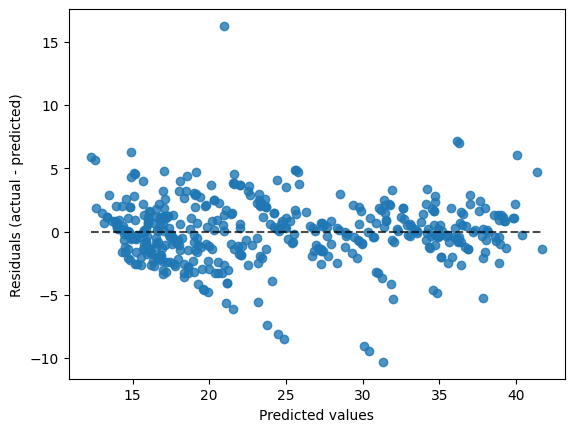

In [293]:
lr = LinearRegression()
lr.fit(df_min, y)
y_min_pred = lr.predict(df_min)
display = PredictionErrorDisplay(y_true=y, y_pred=y_min_pred)
display.plot()

Now add other features in one by one:

In [277]:
results_min = pd.DataFrame(data=0.0, index=features_of_interest, columns=["rsquared", "rsquared_adj"])
for feature in list(results_min.index):
  if feature in min_features:
    continue
  X_big = df_min.join(other=df[feature], on="OBJECTID", how='left', validate='1:1')
  result = ols(X_big, y)
  results_min.loc[feature].rsquared = result.rsquared
  results_min.loc[feature].rsquared_adj = result.rsquared_adj

results_min

,rsquared,rsquared_adj
R_PCTLOWWAGE,0.000000,0.000000
Income,0.000000,0.000000
R_MedWageWk,0.920610,0.918789
D5BR,0.914940,0.912989
D5DR,0.000000,0.000000
...,...,...
E5_Off,0.914939,0.912988
E_LowWageWk,0.915014,0.913065
E8_off,0.915009,0.913060
E8_Ind,0.916090,0.914166


## d. Something else

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
kf = KFold(shuffle=True, random_state=SEED)
lr = LinearRegression()


scores = cross_val_score(lr, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
scores